In [1]:
cd /workspace/fast-influence-functions/

/workspace/fast-influence-functions


In [2]:
# torch.save(influences_collections, "influences_collections-100.tmp.pt")
import torch
import matplotlib.pyplot as plt
from graph_tool.draw import graph_draw
from experiments.visualization import get_graph
from experiments.visualization_utils import plot_influences_distribution
# mnli2_influences_collections = torch.load("/export/share/hguo/Experiments/20200805/mnli2_influences-100.pt")
# # This is HANS-MNLI influence
# hans_influences_collections = torch.load("/export/share/hguo/Experiments/20200811/hans_influences_collections.pt")
# # This is HANS-HANS influence (deprecated)
# hans_influences_collections = torch.load("/export/share/hguo/Experiments/20200818/hans_influences_collections.pt")
influences_collections_list = (
    torch.load("/export/share/hguo/Experiments/20200811/hans_influences_collections.pt") + [
    torch.load("/export/share/hguo/Experiments/20200805/mnli2_influences-100.pt")
])

# influences_collections_list = [
#     torch.load("/export/share/hguo/Experiments/20200904/visualization.100.hans-hans-lexical_overlap-hans.False.pth.g0311.ll.unc.edu"),
#     torch.load("/export/share/hguo/Experiments/20200904/visualization.100.hans-hans-subsequence-hans.False.pth.g0310.ll.unc.edu"),
#     torch.load("/export/share/hguo/Experiments/20200904/visualization.100.hans-hans-constituent-hans.False.pth.g0311.ll.unc.edu"),
#     torch.load("/export/share/hguo/Experiments/20200904/visualization.100.hans-mnli-2-lexical_overlap-hans.False.pth.g0313.ll.unc.edu"),
# ]

/opt/conda/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:1461: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
# x1 = torch.load("/export/share/hguo/Experiments/20200811/hans_influences_collections.pt")
# x2 = torch.load("/export/share/hguo/Experiments/20200818/hans_influences_collections.pt")
# x3 = torch.load("/export/share/hguo/Experiments/20200904/visualization.100.hans-hans-lexical_overlap-hans.False.pth.g0311.ll.unc.edu")
# x4 = torch.load("/export/share/hguo/Experiments/20200904/visualization.100.hans-mnli-2-lexical_overlap-hans.False.pth.g0313.ll.unc.edu")
# x5 = torch.load("/export/share/hguo/Experiments/20200805/mnli2_influences-100.pt")
# print(len(x1[0][0]), len(x2[0][0]), len(x3[0]), len(x4[0]), len(x5[0]))
# print(len(x1), len(x2), len(x3), len(x4), len(x5))

In [4]:
from experiments.misc_utils import sort_dict_keys_by_vals
def prune_train_datapoints(influences_collections_list, n):
    for influences_collections in influences_collections_list:
        for influences_dict in influences_collections:
            sorted_keys = sort_dict_keys_by_vals(influences_dict)
            for k in sorted_keys[n:-n]:
                influences_dict.pop(k)
                    
# prune_train_datapoints(influences_collections_list, 10)

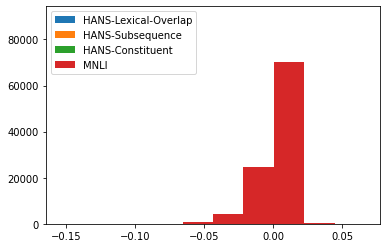

In [5]:
# plot_influences_distribution(mnli2_influences_collections, "MNLI-2")
# for label_index, label in enumerate(["lexical_overlap", "subsequence", "constituent"]):
#     plot_influences_distribution(hans_influences_collections[label_index], label)

plot_influences_distribution(influences_collections_list[0], "HANS-Lexical-Overlap")
plot_influences_distribution(influences_collections_list[1], "HANS-Subsequence")
plot_influences_distribution(influences_collections_list[2], "HANS-Constituent")
plot_influences_distribution(influences_collections_list[3], "MNLI")
plt.legend()

In [6]:
for _hans_influences_collections in influences_collections_list[:3]:
    for L in _hans_influences_collections:
        for key, val in L.items():
            L[key] = val * 100
# for _influences_collections in influences_collections_list:
#     for L in _influences_collections:
#         for key, val in L.items():
#             L[key] = val * 25

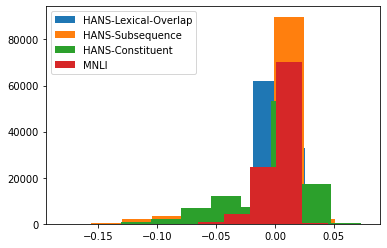

In [7]:
plot_influences_distribution(influences_collections_list[0], "HANS-Lexical-Overlap")
plot_influences_distribution(influences_collections_list[1], "HANS-Subsequence")
plot_influences_distribution(influences_collections_list[2], "HANS-Constituent")
plot_influences_distribution(influences_collections_list[3], "MNLI")
plt.legend()

In [8]:
g, outputs = get_graph(influences_collections_list)

100%|██████████| 112130/112130 [15:31<00:00, 120.39it/s]


In [4]:
import pandas as pd
hans_train_dataset = pd.read_csv("/export/share/hguo/Data/HANS/heuristics_train_set.txt", sep="\t")

hans_train_dataset.heuristic.unique()
train_vertex_color_map = hans_train_dataset.heuristic.apply(
    lambda heuristic: {
        "lexical_overlap": 2,
        "subsequence": 3,
        "constituent": 4}[heuristic])

train_vertex_radius_map = hans_train_dataset.heuristic.apply(
    lambda heuristic: {
        "lexical_overlap": 3,
        "subsequence": 2,
        "constituent": 1}[heuristic])

train_vertex_color_map_fn = lambda index: train_vertex_color_map.values[index]
train_vertex_radius_map_fn = lambda index: train_vertex_radius_map.values[index]

In [ ]:
g, outputs = get_graph(
    influences_collections_list,
    train_vertex_color_map_fn=train_vertex_color_map_fn,
    train_vertex_radius_map_fn=train_vertex_radius_map_fn,
    eval_vertex_radius=4,
)

In [9]:
def get_edge_masks(g, keep_positive: bool):
    edge_pen_widths = g.new_edge_property("double")
    edge_weights = g.edge_properties["weights"]
    edge_signed_influences = g.edge_properties["signed_influences"]
    for e in g.edges():
        if keep_positive:
            if edge_signed_influences[e] >= 0.0:
                edge_pen_widths[e] = edge_weights[e]
            else:
                edge_pen_widths[e] = 0.0
        else:
            if edge_signed_influences[e] < 0.0:
                edge_pen_widths[e] = edge_weights[e]
            else:
                edge_pen_widths[e] = 0.0
    return edge_pen_widths

In [10]:
import matplotlib.cm as plt_cm
from experiments.visualization import (
    DEFAULT_HELPFUL_EDGE_COLOR,
    DEFAULT_HARMFUL_EDGE_COLOR,
    DEFAULT_TRAIN_VERTEX_COLOR)
edge_color_map_dict = {
    DEFAULT_HELPFUL_EDGE_COLOR: [64, 122, 120],
    DEFAULT_HARMFUL_EDGE_COLOR: [235, 167, 136],
}

vertex_color_map_dict = {
    0 / 4: [192, 192, 192],
    1 / 4: [242, 242, 242],
    2 / 4: [221, 129, 130],
    3 / 4: [91, 145, 166],
    4 / 4: [191, 163, 138],
}

# vertex_color_map_dict = {
#     0 / 3: [242, 242, 242],
#     1 / 3: [221, 129, 130],
#     2 / 3: [91, 145, 166],
#     3 / 3: [191, 163, 138],
# }

def edge_color_map(c, alpha):
    if alpha is None:
        alpha = 1.0
    rgb = edge_color_map_dict[c]
    normalized_rgb = [x / 255 for x in rgb]
    return normalized_rgb + [alpha]


def vertex_color_map(c, alpha):
    if alpha is None:
        alpha = 0.75
    rgb = vertex_color_map_dict[c]
    normalized_rgb = [x / 255 for x in rgb]
    return normalized_rgb + [alpha]

In [11]:
def plot(g):
    outputs_positive = graph_draw(g,
               pos=g.vertex_properties["positive_positions"],
               edge_color=g.edge_properties["colors"],
               vertex_size=g.vertex_properties["sizes"],
               vertex_fill_color=g.vertex_properties["colors"],
               vcmap=vertex_color_map,
               ecmap=edge_color_map,
               output_size=(750, 750),
               edge_pen_width=get_edge_masks(g, keep_positive=True),
               # vertex_text=g.vertex_properties["data_indices"],
               # vertex_font_size=5,
               output="20201111.mnli2.harmful.png"
              )

    outputs_negative = graph_draw(g,
               pos=g.vertex_properties["negative_positions"],
               edge_color=g.edge_properties["colors"],
               vertex_size=g.vertex_properties["sizes"],
               vertex_fill_color=g.vertex_properties["colors"], 
               vcmap=vertex_color_map,
               ecmap=edge_color_map,
               output_size=(750, 750),
               edge_pen_width=get_edge_masks(g, keep_positive=False),
               # vertex_text=g.vertex_properties["data_indices"],
               # vertex_font_size=5,
               output="20201111.mnli2.helpful.png"

    )

    return outputs_positive, outputs_negative

outputs_positive, outputs_negative = plot(g)

In [14]:
import plotly.graph_objects as go
def make_interactive_graph(vertex_positions, vertex_colors, vertex_data_indices, edge_unsigned_influences, color):
    edge_x = []
    edge_y = []
    edge_opacity = []
    for edge in g.edges():
        x0, y0 = vertex_positions[edge.source()]
        x1, y1 = vertex_positions[edge.target()]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(-y0)
        edge_y.append(-y1)
        edge_y.append(None)
        edge_opacity.append(edge_unsigned_influences[edge])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        opacity=0.5,
        line=dict(width=0.5, color=color),
        hoverinfo=None,
        mode="lines")

    node_x = []
    node_y = []
    node_color = []
    node_description = []
    for vertex in g.vertices():
        x, y = vertex_positions[vertex]
        node_x.append(x)
        node_y.append(-y)
        node_color.append(vertex_colors[vertex])
        data_index = vertex_data_indices[vertex]
        if data_index.startswith("train"):
            description = get_string_from_train(int(data_index.split("-")[-1]))
            node_description.append(description)
        if data_index.startswith("eval"):
            a, b = data_index.split("-")[1:]
            description = get_string_from_eval(int(a), int(b))
            node_description.append(description)
        

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        hoverinfo="text",
        text=node_description,
        hovertemplate="%{text}",
        marker=dict(
            showscale=True,
            colorscale="YlGnBu",
            reversescale=True,
            color=node_color,
            size=10,
            line_width=2))
    
    # create our callback function
    def update_point(trace, points, selector):
        raise ValueError
        opacities = [0.25 for _ in range(len(node_trace.marker.color))]
        for i in points.point_inds:
            opacities[i] = 1.0
            with fig.batch_update():
                node_trace.marker.opacity = opacities
    
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
    # fig.show()
    fig.data[1].on_click(update_point)
    return fig

In [15]:
fig = make_interactive_graph(
    vertex_positions=g.vertex_properties["positive_positions"],
    vertex_colors=g.vertex_properties["colors"],
    vertex_data_indices=g.vertex_properties["data_indices"],
    edge_unsigned_influences=g.edge_properties["unsigned_influences"],
    color="brown")

In [ ]:
fig

In [17]:
from jupyter_dash import JupyterDash

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
# JupyterDash.infer_jupyter_proxy_config()


app = JupyterDash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False, mode="inline")  # Turn off reloader if inside Jupyter

In [13]:
make_interactive_graph(
    vertex_positions=g.vertex_properties["negative_positions"],
    vertex_colors=g.vertex_properties["colors"],
    vertex_data_indices=g.vertex_properties["data_indices"],
    color="skyblue")

In [11]:
# cd /workspace/fast-influence-functions/

In [12]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [13]:
# from experiments.visualization import *
# from tqdm import tqdm
# from experiments import visualization
# def main(
#     train_task_name: str,
#     eval_task_name: str,
#     num_eval_to_collect: int,
#     use_parallel: Optional[bool] = True,
#     hans_heuristic: Optional[str] = None,
#     trained_on_task_name: Optional[str] = None,
# ) -> List[Dict[int, float]]:

#     if train_task_name not in ["mnli-2", "hans"]:
#         raise ValueError

#     if eval_task_name not in ["mnli-2", "hans"]:
#         raise ValueError

#     if trained_on_task_name is None:
#         # The task the model was trained on
#         # can be different from `train_task_name`
#         # which is used to determine on which the
#         # influence values will be computed.
#         trained_on_task_name = train_task_name

#     if trained_on_task_name not in ["mnli-2", "hans"]:
#         raise ValueError

#     # `trained_on_task_name` determines the model to load
#     if trained_on_task_name in ["mnli-2"]:
#         tokenizer, model = misc_utils.create_tokenizer_and_model(
#             constants.MNLI2_MODEL_PATH)

#     if trained_on_task_name in ["hans"]:
#         tokenizer, model = misc_utils.create_tokenizer_and_model(
#             constants.HANS_MODEL_PATH)

#     train_dataset, _ = misc_utils.create_datasets(
#         task_name=train_task_name,
#         tokenizer=tokenizer)

#     _, eval_dataset = misc_utils.create_datasets(
#         task_name=eval_task_name,
#         tokenizer=tokenizer)

#     if trained_on_task_name == "mnli-2" and train_task_name == "mnli-2":
#         faiss_index = faiss_utils.FAISSIndex(768, "Flat")
#         faiss_index.load(constants.MNLI2_FAISS_INDEX_PATH)
#     elif trained_on_task_name == "hans" and train_task_name == "hans":
#         faiss_index = faiss_utils.FAISSIndex(768, "Flat")
#         faiss_index.load(constants.HANS_FAISS_INDEX_PATH)
#     elif trained_on_task_name == "mnli-2" and train_task_name == "hans":
#         faiss_index = faiss_utils.FAISSIndex(768, "Flat")
#         faiss_index.load(constants.MNLI2_HANS_FAISS_INDEX_PATH)
#     elif trained_on_task_name == "hans" and train_task_name == "mnli-2":
#         faiss_index = faiss_utils.FAISSIndex(768, "Flat")
#         faiss_index.load(constants.HANS_MNLI2_FAISS_INDEX_PATH)
#     else:
#         faiss_index = None

#     trainer = Trainer(
#         model=model,
#         args=TrainingArguments(
#             output_dir="./tmp-output",
#             per_device_train_batch_size=128,
#             per_device_eval_batch_size=128,
#             learning_rate=5e-5,
#             logging_steps=100),
#         train_dataset=train_dataset,
#         eval_dataset=eval_dataset,
#     )

#     if eval_task_name in ["mnli-2"]:
#         eval_instance_data_loader = misc_utils.get_dataloader(
#             dataset=eval_dataset,
#             batch_size=1,
#             random=False)

#     if eval_task_name in ["hans"]:
#         if hans_heuristic is None:
#             raise ValueError("`hans_heuristic` cannot be None for now")

#         hans_helper = HansHelper(
#             hans_train_dataset=None,
#             hans_eval_dataset=eval_dataset)

#         _, eval_instance_data_loader = hans_helper.get_dataset_and_dataloader_of_heuristic(
#             mode="eval",
#             heuristic=hans_heuristic,
#             batch_size=1,
#             random=False)

#     # Data-points where the model got wrong
#     wrong_input_collections = []
#     for i, test_inputs in enumerate(tqdm(eval_instance_data_loader)):
#         logits, labels, step_eval_loss = misc_utils.predict(
#             trainer=trainer,
#             model=model,
#             inputs=test_inputs)
#         if logits.argmax(axis=-1).item() != labels.item():
#             wrong_input_collections.append(test_inputs)
        
#         if len(wrong_input_collections) == num_eval_to_collect:
#             break
    
#     return wrong_input_collections, tokenizer, model, train_dataset, eval_dataset


In [10]:
# wrong_input_collections_lexicaloverlap = main(
#     train_task_name="hans",
#     eval_task_name="hans",
#     num_eval_to_collect=100,
#     hans_heuristic="lexical_overlap",
#     trained_on_task_name="hans")

# wrong_input_collections_subsequence = main(
#     train_task_name="hans",
#     eval_task_name="hans",
#     num_eval_to_collect=100,
#     hans_heuristic="subsequence",
#     trained_on_task_name="hans")

# wrong_input_collections_constituent = main(
#     train_task_name="hans",
#     eval_task_name="hans",
#     num_eval_to_collect=100,
#     hans_heuristic="constituent",
#     trained_on_task_name="hans")

# wrong_input_collections_mnli2 = main(
#     train_task_name="hans",
#     eval_task_name="mnli-2",
#     num_eval_to_collect=100,
#     hans_heuristic=None,
#     trained_on_task_name="hans")

In [9]:
# torch.save({
#     "lexical_overlap": wrong_input_collections_lexicaloverlap,
#     "subsequence": wrong_input_collections_subsequence,
#     "constituent": wrong_input_collections_constituent,
#     "mnli-2": wrong_input_collections_mnli2
# }, "/export/share/hguo/Experiments/20200909/wrong_input_collections.pt")

In [13]:
from experiments import mnli_utils, misc_utils, constants

tokenizer, _ = misc_utils.create_tokenizer_and_model(
    constants.HANS_MODEL_PATH)

wrong_input_collections_list = torch.load(
    "/export/share/hguo/Experiments/20200909/wrong_input_collections.pt")

wrong_input_collections_dict = [
    wrong_input_collections_list["lexical_overlap"][0],
    wrong_input_collections_list["subsequence"][0],
    wrong_input_collections_list["constituent"][0],
    wrong_input_collections_list["mnli-2"][0],
]

label_list_dict = [
    wrong_input_collections_list["lexical_overlap"][3].label_list,
    wrong_input_collections_list["subsequence"][3].label_list,
    wrong_input_collections_list["constituent"][3].label_list,
    wrong_input_collections_list["mnli-2"][3].label_list,
]

def get_string_from_eval(i, index):
    inputs = wrong_input_collections_dict[i][index]
    premise, hypothesis, label = (
        mnli_utils.get_data_from_features_or_inputs(
            tokenizer=tokenizer,
            label_list=label_list_dict[i],
            feature=None,
            inputs=inputs))
    
    return f"P:{premise}\nH:{hypothesis}\nL:{label}"

def get_string_from_train(index):
    entry = hans_train_dataset.iloc[index]
    return f"P:{entry.sentence1}\nH:{entry.sentence2}\nL:{entry.gold_label}"

Params Trainable: 14767874
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke